In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import pandas_profiling
import statsmodels.api as sm

import matplotlib.pylab as plt
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

## Loading Data

In [4]:
df_data = pd.read_json('data.json', lines=True)
df_data.head()

,cluster,comments,date_formated,date_month,date_unix,date_week,hashtags,id,likes,url,user_id
0,buzzcut,19,01-01-2017,1,1483292238,52,"[#shooting, #photography, #studiophotography, ...",BOuvqVnA8or,269,https://scontent-vie1-1.cdninstagram.com/t51.2...,2963637811
1,chignon,38,01-01-2017,1,1483293222,52,"[#chignon, #insta, #instapic, #liveyourlife, #...",BOuxiZXBee-,222,https://scontent-vie1-1.cdninstagram.com/t51.2...,2897380111
2,wetlook,15,01-01-2017,1,1483305481,52,"[#happynewyear, #magic, #christmas, #look, #ch...",BOvI621jm4n,182,https://scontent-vie1-1.cdninstagram.com/t51.2...,190130788
3,hairflip,18,01-01-2017,1,1483310388,52,"[#2017whatsgood, #nyc, #nye, #toshi, #firstNYE...",BOvSR4OgxAq,112,https://scontent-vie1-1.cdninstagram.com/t51.2...,181138901
4,halfupdo,28,01-01-2017,1,1483294337,52,"[#braidphoto, #velvetdress, #braidideas, #hair...",BOuzqkSAO_7,174,https://scontent-vie1-1.cdninstagram.com/t51.2...,1963048049


## Exposing Fundamental Info About Data

In [5]:
display(df_data.describe())
display(df_data.info())

,comments,date_month,date_unix,date_week,likes,user_id
count,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,1.000000e+04
mean,3.108700,1.95330,1.485768e+09,18.312900,56.343700,1.692523e+09
std,23.615441,0.69323,1.774091e+06,20.273581,68.537291,1.481797e+09
min,0.000000,1.00000,1.483225e+09,5.000000,0.000000,1.174800e+04
25%,0.000000,1.00000,1.483308e+09,5.000000,19.750000,2.808167e+08
50%,1.000000,2.00000,1.485952e+09,5.000000,37.000000,1.463377e+09
75%,3.000000,2.00000,1.485986e+09,52.000000,68.000000,3.009536e+09
max,2311.000000,3.00000,1.488409e+09,52.000000,2808.000000,4.742553e+09


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
cluster          10000 non-null object
comments         10000 non-null int64
date_formated    10000 non-null object
date_month       10000 non-null int64
date_unix        10000 non-null int64
date_week        10000 non-null int64
hashtags         10000 non-null object
id               10000 non-null object
likes            10000 non-null int64
url              10000 non-null object
user_id          10000 non-null int64
dtypes: int64(6), object(5)
memory usage: 937.5+ KB


None

## Feature Extraction

In [6]:

def __convert_to_day_part(ts):

    if (0 == ts.hour and ts.minute == 0):
        return 'midnight'
    elif (0 <= ts.hour and ts.hour <= 5):
        return 'early_morning'
    elif (6 == ts.hour and ts.minute == 0):
        return 'dawn'
    elif (6 <= ts.hour and ts.hour <= 11):
        return 'morning'
    elif (12 == ts.hour and ts.minute == 0):
        return 'midday'
    elif (12 <= ts.hour and ts.hour <= 17):
        return 'afternoon'
    elif (18 == ts.hour and ts.minute == 0):
        return 'dusk'
    elif (18 <= ts.hour and ts.hour <= 23):
        return 'evening'

# extracting some features over date to take look at the details of dataset
df_data['post_date'] = pd.to_datetime(df_data['date_unix'],unit='s')
df_data['dow'] = df_data['post_date'].apply(lambda t : t.isoweekday())
df_data['day'] = df_data['post_date'].apply(lambda t : t.day)
df_data['month'] = df_data['post_date'].apply(lambda t : t.month)
df_data['year'] = df_data['post_date'].apply(lambda t : t.year)
df_data['daypart'] = df_data['post_date'].apply(__convert_to_day_part)
df_data['n_tags'] = df_data['hashtags'].apply(len)

# df_data['quarter'] = df_data['date_formated'].apply(lambda t : t.quarter)
# df_data['is_weekend'] = df_data['dow'].apply(lambda t : 1 if t == 6 or t == 7 else 0) * 1
# df_data['is_month_start'] = df_data['date_formated'].apply(lambda t : t.is_month_start) * 1
# df_data['is_month_end'] = df_data['date_formated'].apply(lambda t : t.is_month_end) * 1
# df_data['is_quarter_start'] = df_data['date_formated'].apply(lambda t : t.is_quarter_start) * 1
# df_data['is_quarter_end'] = df_data['date_formated'].apply(lambda t : t.is_quarter_end) * 1
# df_data['is_year_start'] = df_data['date_formated'].apply(lambda t : t.is_year_start) * 1
# df_data['is_year_end'] = df_data['date_formated'].apply(lambda t : t.is_year_end) * 1
# df_data['log_comments'] = df_data['comments'].apply(np.log1p)
# df_data['log_likes'] = df_data['likes'].apply(np.log1p)

df_data.drop(['date_month', 'id', 'url', 'date_unix'], 1, inplace=True, errors='ignore')

df_data.head()

,cluster,comments,date_formated,date_week,hashtags,likes,user_id,post_date,dow,day,month,year,daypart,n_tags
0,buzzcut,19,01-01-2017,52,"[#shooting, #photography, #studiophotography, ...",269,2963637811,2017-01-01 17:37:18,7,1,1,2017,afternoon,29
1,chignon,38,01-01-2017,52,"[#chignon, #insta, #instapic, #liveyourlife, #...",222,2897380111,2017-01-01 17:53:42,7,1,1,2017,afternoon,23
2,wetlook,15,01-01-2017,52,"[#happynewyear, #magic, #christmas, #look, #ch...",182,190130788,2017-01-01 21:18:01,7,1,1,2017,evening,27
3,hairflip,18,01-01-2017,52,"[#2017whatsgood, #nyc, #nye, #toshi, #firstNYE...",112,181138901,2017-01-01 22:39:48,7,1,1,2017,evening,10
4,halfupdo,28,01-01-2017,52,"[#braidphoto, #velvetdress, #braidideas, #hair...",174,1963048049,2017-01-01 18:12:17,7,1,1,2017,evening,28


## Data Profiling

In [5]:
pandas_profiling.ProfileReport(df_data)

Number of variables,14
Number of observations,10000
Total Missing (%),0.0%
Total size in memory,1.1 MiB
Average record size in memory,120.0 B
Numeric,7
Categorical,3
Boolean,1
Date,1
Text (Unique),0
Rejected,1


## CDFs of Cont. Variables ('n_tags','likes', 'comments')

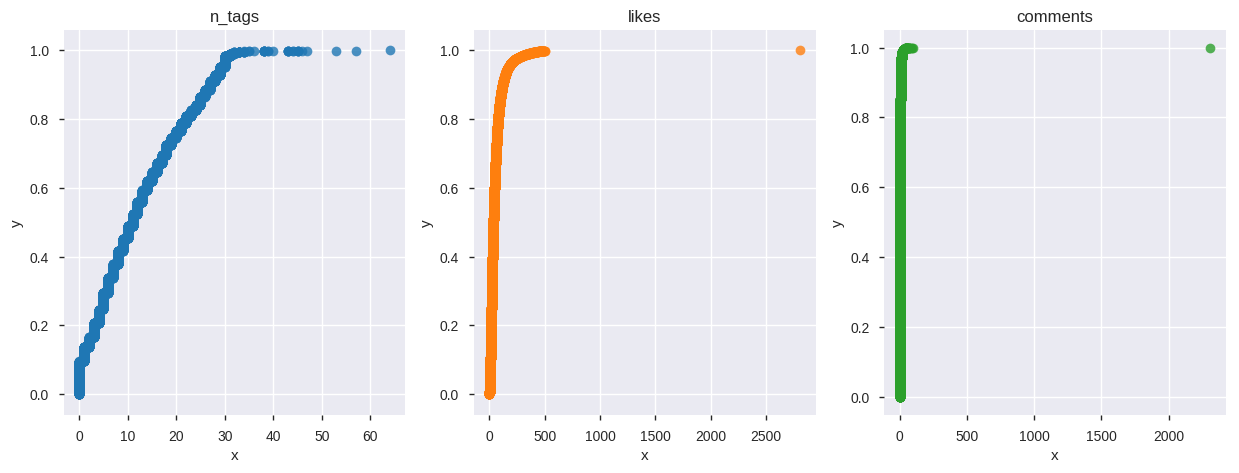

In [18]:
features = ['n_tags','likes', 'comments']
fig, axes = plt.subplots(1, len(features), figsize=(15, 5))
for i, f in enumerate(features):
    ecdf = sm.distributions.ECDF(df_data[f])
    ecdf = pd.DataFrame({'x' : ecdf.x,'y' : ecdf.y})
    ecdf.replace(float('-inf'), 0, inplace=True)
    g = sns.regplot(x='x', y='y', fit_reg=False, scatter=True, data=ecdf, ax=axes[i])
    g.set_title(f)
#     g.set_xscale('log')

## Daily Distribution of Cont. Variables ('n_tags','likes', 'comments')

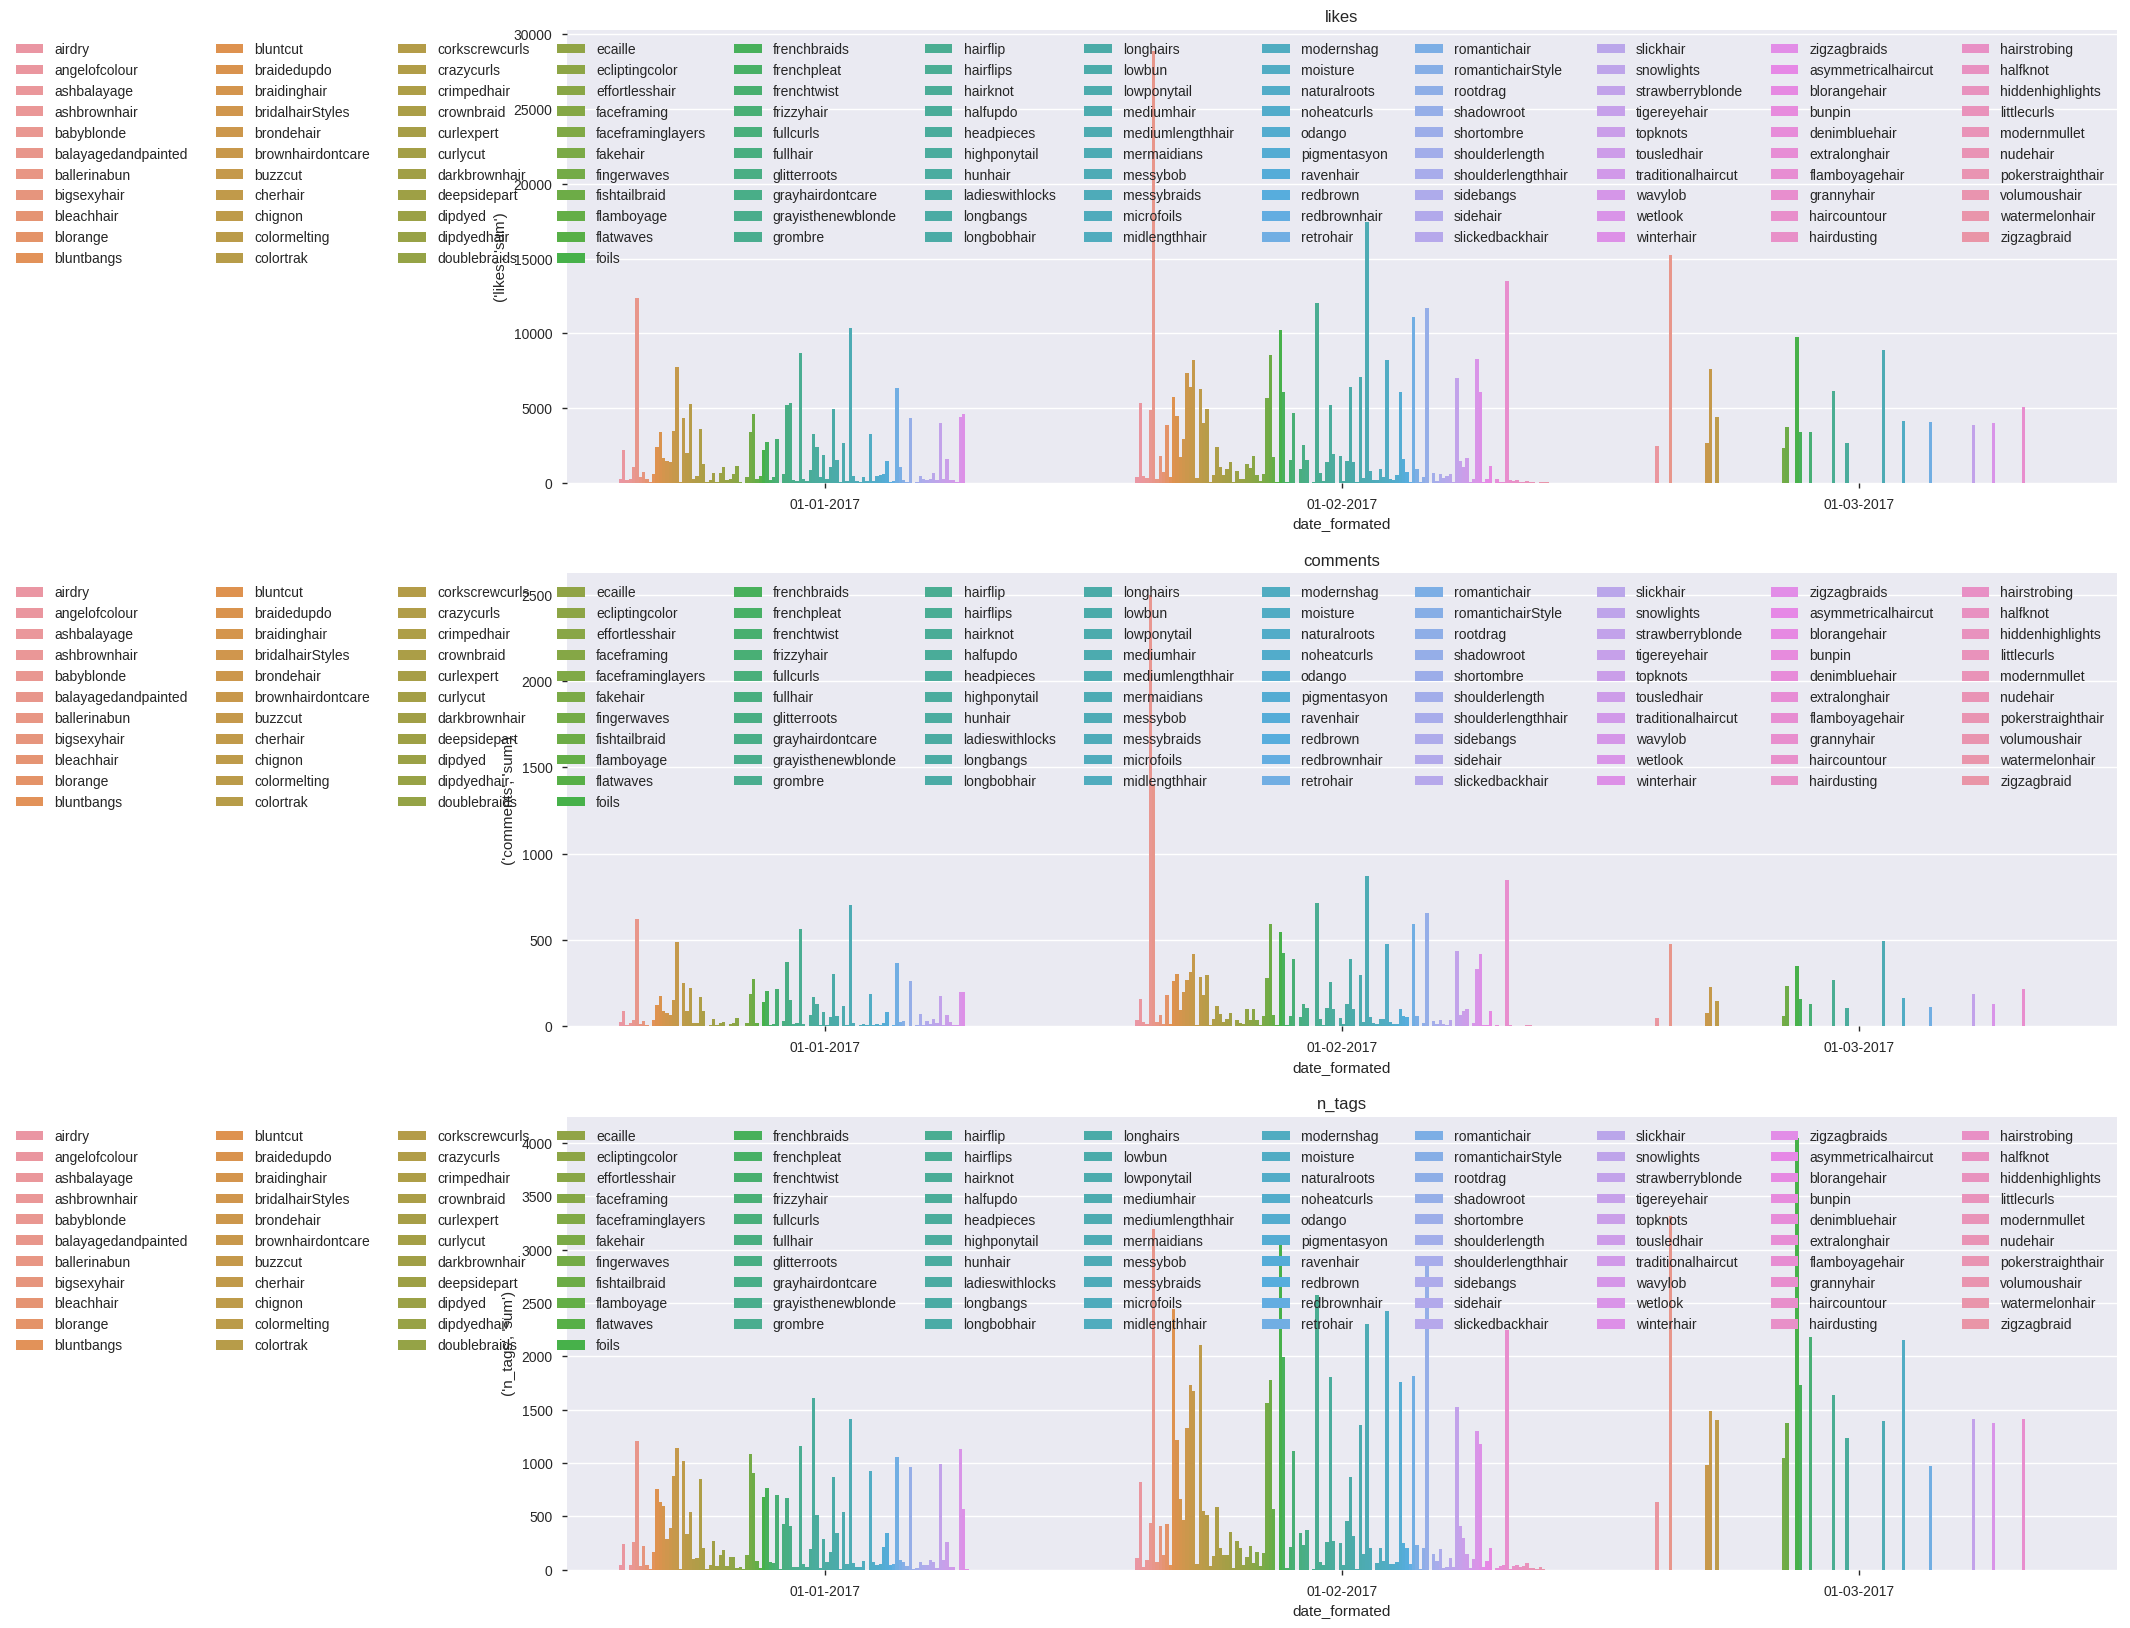

In [53]:
features = ['likes', 'comments', 'n_tags']

agg_f = {f :[sum] for f in features}
df_temp = df_data.groupby(['date_formated', 'cluster']).aggregate(agg_f).reset_index()

fig, axes = plt.subplots(len(features), 1, figsize=(20, 20))
for i, f in enumerate(features):
    ax = sns.barplot(x='date_formated', y=(f, 'sum'), hue='cluster', data=df_temp, ax=axes[i])
    ax.set_title(f)
    ax.legend(ncol=12)

## Daily Distribution of Cont. Variables ('n_tags','likes', 'comments')

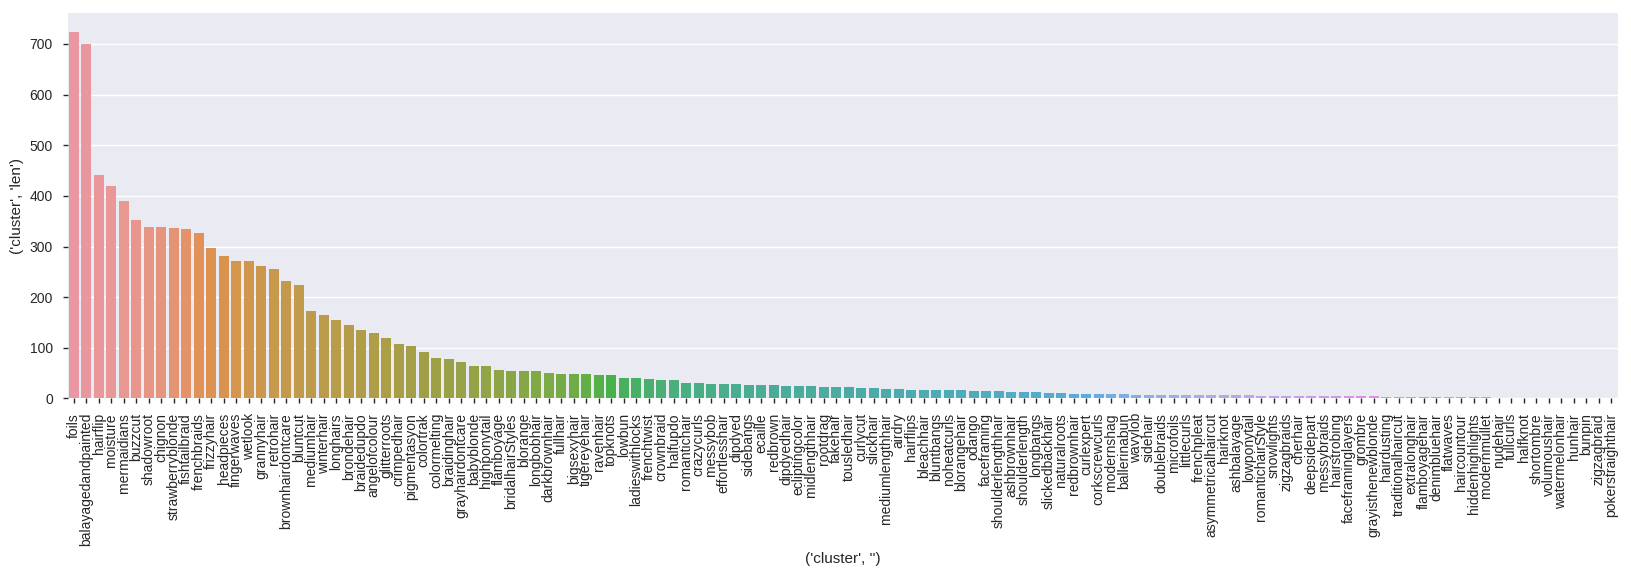

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
df_tmp = df_data[['cluster']].groupby(['cluster']).aggregate({'cluster' : [len]}).sort_values(('cluster', 'len'), ascending=False).reset_index()
g = sns.barplot(x=('cluster',''), y=('cluster', 'len'), data=df_tmp)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Plotboxing for Cont. Variables

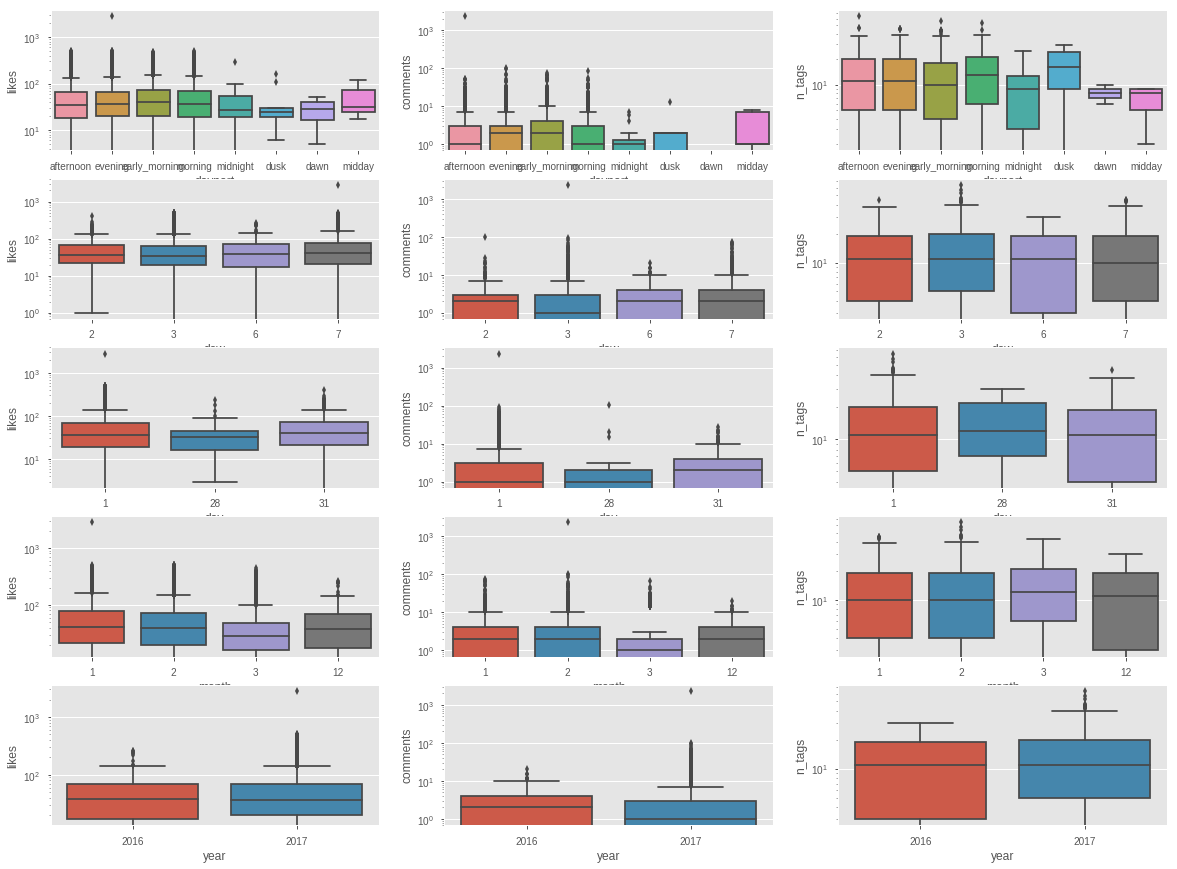

In [27]:
features = ['daypart','dow', 'day', 'month', 'year']
fig, axes = plt.subplots(len(features), 3, figsize=(20, 15))
for i, f in enumerate(features):
    g = sns.boxplot(x=f, y='likes', data=df_data, ax=axes[i][0])
    g.set_yscale('log')
    
    g = sns.boxplot(x=f, y='comments', data=df_data, ax=axes[i][1])
    g.set_yscale('log')
    
    g = sns.boxplot(x=f, y='n_tags', data=df_data, ax=axes[i][2])
    g.set_yscale('log')

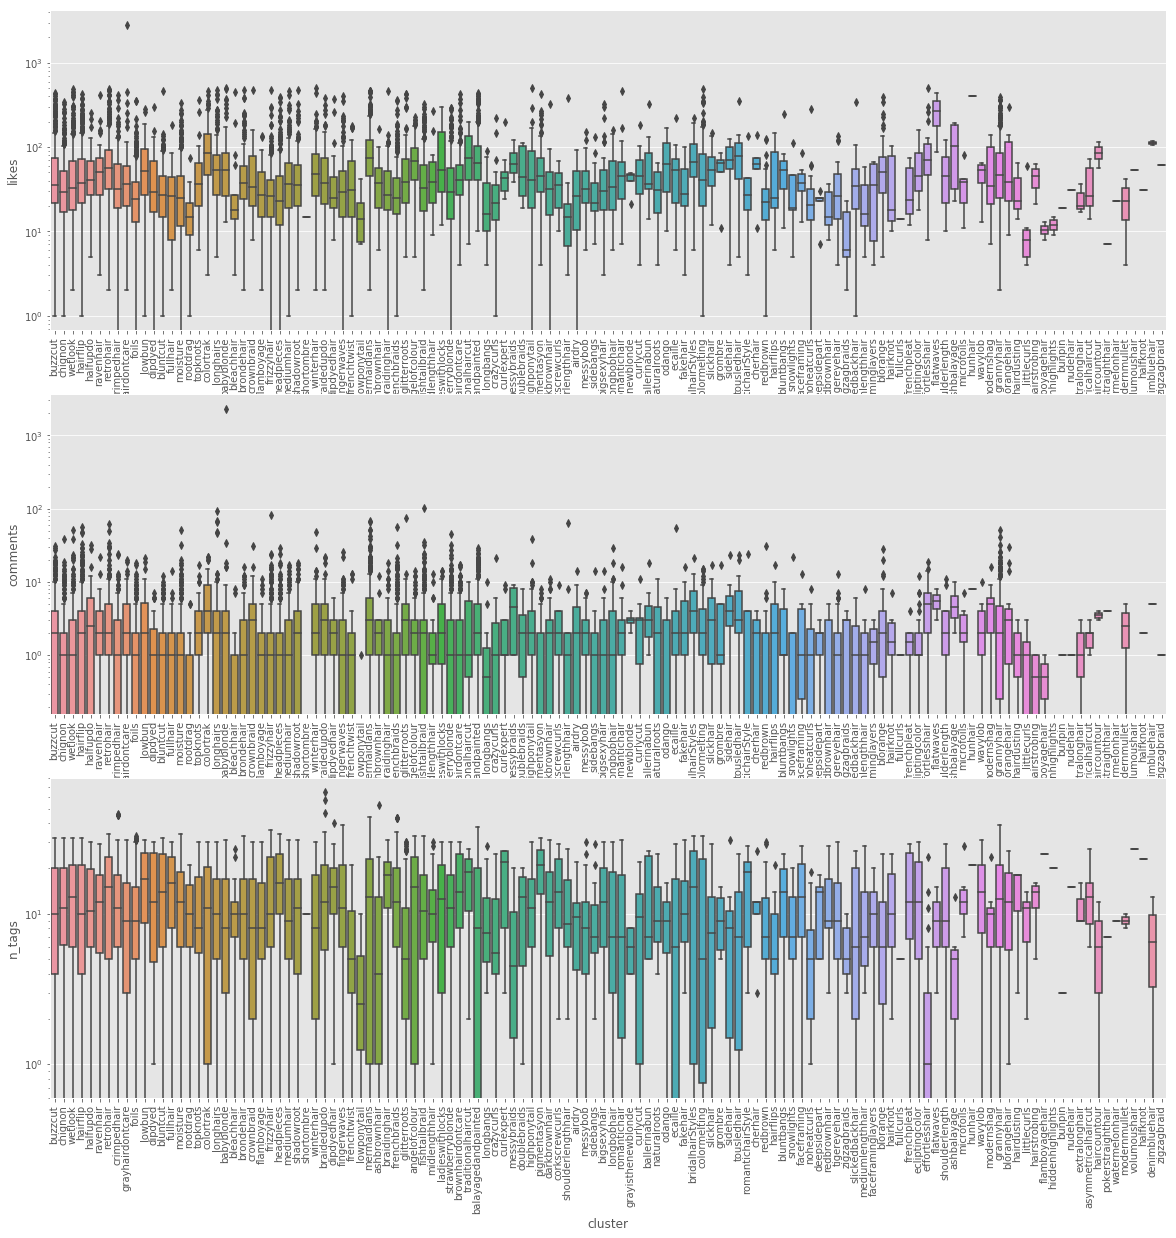

In [9]:
features = ['likes', 'comments', 'n_tags']
fig, axes = plt.subplots(len(features), 1, figsize=(20, 20))
for i, f in enumerate(features):
    g = sns.boxplot(x='cluster', y=f, data=df_data, ax=axes[i])
    g.set_yscale('log')
    g.set_xticklabels(g.get_xticklabels(), rotation=90);

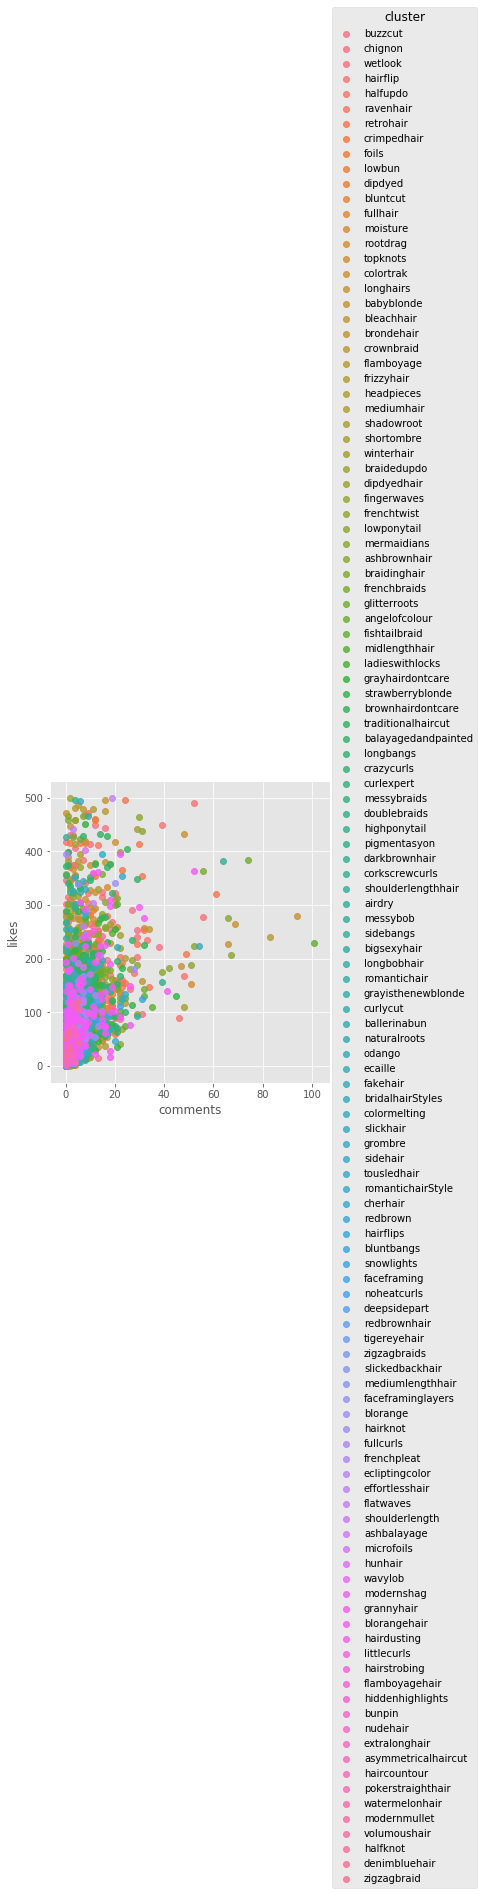

In [29]:
df_tmp = df_data[(df_data['comments'] < 2000) & (df_data['likes'] < 2500)]

g = sns.lmplot(x='comments', y='likes', hue='cluster', fit_reg=False, scatter=True, data=df_tmp)

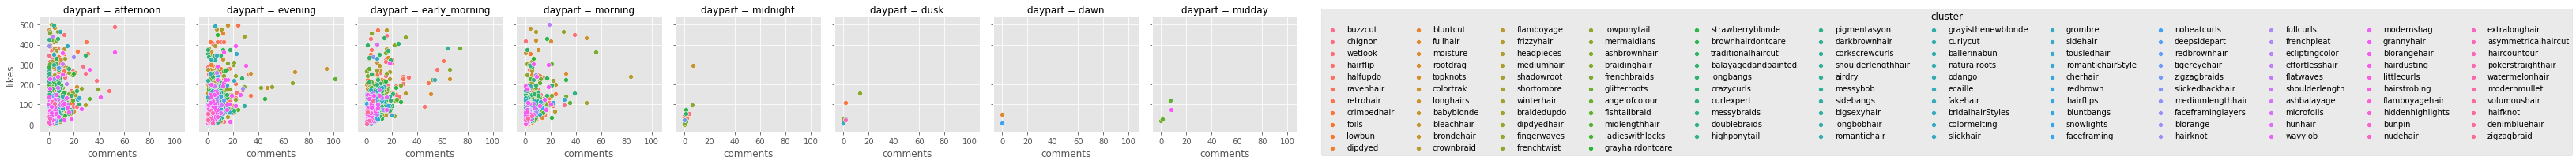

In [21]:
df_tmp = df_data[(df_data['comments'] < 2000) & (df_data['likes'] < 2500)]

g = sns.FacetGrid(df_tmp, col='daypart',  hue='cluster')
g = (g.map(plt.scatter, 'comments', 'likes', edgecolor="w").add_legend(ncol=12))

# Hastags Analysis and Fitting a Model by Using LightGBM

In [8]:
df_data['hastags'] = df_data['hashtags'].apply(lambda x :  ','.join(x).lower().replace('#', ''))

### Number of Unique Hashtags

In [10]:
nltk.download('stopwords')
eng = stopwords.words('english')

count_vector_params = {
    'ngram_range': (1, 1),
    'stop_words': eng,
    'dtype': np.float32,
    'token_pattern': r'\w{1,}'
}

count_vec = CountVectorizer(**count_vector_params)
count_vec.fit_transform(df_data['hastags'])

df_words = pd.DataFrame(list(count_vec.vocabulary_.items()), columns=['word', 'count']).sort_values(['count'], ascending=False).reset_index(drop=True)
display(df_words.head())
display(df_words.describe())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,count
0,zurich,34035
1,zur,34034
2,zuppe,34033
3,zumschlussvolls,34032
4,zumindesteigentlich,34031


,count
count,34036.000000
mean,17017.500000
std,9825.491218
min,0.000000
25%,8508.750000
50%,17017.500000
75%,25526.250000
max,34035.000000


In [15]:
import gc
import threading
import zipfile
from time import sleep

import lightgbm as lightgbm
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

if __name__ == '__main__':

    # Calculate count of cluster per cluster by aggregation
    df_agg = df_data[['cluster']].groupby(['cluster']).aggregate({'cluster' : ['count']}).sort_values([('cluster', 'count')])
    print(df_agg, len(df_data))

    # Filtering out the most frequently occurring clusters in data
    f_list = df_agg[df_agg[('cluster', 'count')] > 100].index.tolist()
    df_data = df_data[df_data['cluster'].apply(lambda x: x in f_list)]

    # Re-arranging cluster ids
    lblEncoder = LabelEncoder()
    lblEncoder.fit(df_data['cluster'])
    df_data['cluster'] = lblEncoder.transform(df_data['cluster'])

    # Get raw text from products
    df_data_X = df_data['hastags']
    df_data_y = df_data['cluster']
    
    num_class = len(np.unique(df_data_y))

    # Split the data between training and test set
    df_train_X, df_text_X, df_train_y, df_test_y = train_test_split(df_data_X, df_data_y, test_size=0.2, random_state=112358)

    def run():
        __K = 3
        __r = 3
        __N = __K * __r
        __delay = 10  # second

        __threads = []
        __predictions = pd.DataFrame(columns=list(range(1, __N + 1)), index=range(len(df_test_y)))

        nltk.download('stopwords')
        
        # Collecting Stopwords for each different language, Russian, German and English
        eng = stopwords.words('english')

        __count_vector_params = {
            'ngram_range': (1, 2),
            'stop_words': eng,
#             'max_features': 500,
            'dtype': np.float32,
            'token_pattern': r'\w{1,}'
        }

        __tfidf_params = {
            'sublinear_tf': True,
            'norm': 'l2',
            'smooth_idf': False
        }

        __svd_params = {
            'n_components': 100,
            'random_state': 12435
        }

        __lgbm_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'metric': 'auc',
            'max_depth': 32,
            'num_leaves': 100,
            'learning_rate': 0.01,
            'verbose': 0,
            'seed': 12341,
            'colsample_bytree': 0.95,
            'subsample': 0.95,
            'num_class' : num_class,
        }

        def __run(k, train_index, valid_index):

            X_train, X_valid = df_train_X.iloc[train_index].copy().reset_index(drop=True), \
                               df_train_X.iloc[valid_index].copy().reset_index(drop=True)

            y_train, y_valid = df_train_y.iloc[train_index].copy().reset_index(drop=True), \
                               df_train_y.iloc[valid_index].copy().reset_index(drop=True)

            X_test = df_text_X.copy()

            X_train, X_valid, X_test = __transform_X(k, [X_train.values, X_valid.values, X_test.values])

            model = __create_model(k, X_train, y_train, X_valid, y_valid)
            __predictions[k] = model.predict(X_test)

            __free([X_train, X_valid, X_test, y_train, y_valid, model])

        def __transform_X(k, Xs):

            print('Fold#{} Transformation was started'.format(k))
            assert len(Xs) == 3

            pipeline = Pipeline([
                ('bow', CountVectorizer(**__count_vector_params)),
                ('tfidf', TfidfTransformer(**__tfidf_params)),
                ('svd', TruncatedSVD(**__svd_params)),
            ])

            pipeline.fit(Xs[0])
            result =  tuple([pipeline.transform(x) for x in Xs])
            print('Fold#{} Transformation was done'.format(k))

            return result

        def __create_model(k, X_train, y_train, X_valid, y_valid):

            print('Fold#{} Model creation was started'.format(k))

            train_dataset = lightgbm.Dataset(X_train,
                                             y_train)

            valid_dataset = lightgbm.Dataset(X_valid,
                                             y_valid)

            model = lightgbm.train(
                __lgbm_params,
                train_dataset,
                num_boost_round=500,
                valid_sets=[valid_dataset, train_dataset],
                valid_names=['valid-{}-{}'.format(k, __N), 'train-{}-{}'.format(k, __N)],
                early_stopping_rounds=50,
                verbose_eval=5,
            )

            print('Fold#{} Model creation was done'.format(k))

            return model

        def __free(objs):
            for x in objs:
                del x
            gc.collect()

        def __evaluate():
            __wait()
            y_test_prediction = __predictions.mean(1)

            auc_scores = {}
            pre_scores = {}
            fpr = {}
            tpr = {}

            pre_micro = {}
            pre_macro = {}

            for c in np.unique(df_test_y):
                y_test_actual = df_test_y.copy()
                y_test_actual = (y_test_actual == c) * 1

                fpr[c], tpr[c], _ = roc_curve(y_test_actual, y_test_prediction)
                auc_scores[c] = roc_auc_score(y_test_actual, y_test_prediction)
                pre_scores[c] =  fpr[c] / (fpr[c] + tpr[c])

                # https: // sebastianraschka.com / faq / docs / multiclass - metric.html
                pre_micro[c] = sum(fpr[c]) / sum(fpr[c] + tpr[c])
                pre_macro[c] = np.mean(pre_scores[c])

            df_res = pd.DataFrame()
            df_res['cluster'] = lblEncoder.inverse_transform(np.unique(df_test_y))
            df_res['auc'] = list(auc_scores.values())
            df_res['pre_micro'] = list(pre_micro.values())
            df_res['pre_macro'] = list(pre_macro.values())

            df_des = df_res.describe()

            df_res.to_csv('result.csv', index=False)
            df_des.to_csv('statistics.csv')


        def __wait():
            for k in range(__N):
                __threads[k].join()
                print('Fold#{} was done...'.format(k))

        kf = RepeatedStratifiedKFold(n_splits=__K, n_repeats=__r, random_state=112358)

        k = 1
        for train_index, valid_index in kf.split(df_train_X, df_train_y):
            t = threading.Thread(target=__run, args=(k, train_index, valid_index))

            t.start()
            __threads.append(t)

            print('Sleeping {} seconds'.format(__delay))
            sleep(__delay)

            print('Fold#{} was started...'.format(k))
            k += 1

        __evaluate()

    run()

        cluster
          count
cluster        
22          103
8           107
14          119
0           130
3           136
4           145
18          155
27          165
19          173
2           225
5           232
23          255
15          262
9           272
26          272
17          281
13          298
12          327
10          334
25          336
7           338
24          339
6           352
20          389
21          420
16          441
1           700
11          724 8030
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Sleeping 10 seconds
Fold#1 Transformation was started
Fold#1 Transformation was done
Fold#1 Model creation was started
Training until validation scores don't improve for 50 rounds.
[5]	train-1-9's auc: 0.0265125	valid-1-9's auc: 0.13459
Fold#1 was started...
Sleeping 10 seconds
Fold#2 Transformation was started
Fold#2 Transformation was done
Fold#2 Model creation was started
Tr

[45]	train-9-9's auc: 0.0220753	valid-9-9's auc: 0.049632
Early stopping, best iteration is:
[1]	train-6-9's auc: 0.0257131	valid-6-9's auc: 0.0567677
Fold#6 Model creation was done
Fold#5 was done...
[50]	train-7-9's auc: 0.0227345	valid-7-9's auc: 0.0512101
Early stopping, best iteration is:
[2]	train-7-9's auc: 0.0281241	valid-7-9's auc: 0.074759
Fold#7 Model creation was done
Fold#6 was done...
[50]	train-8-9's auc: 0.0250939	valid-8-9's auc: 0.0709683
[50]	train-9-9's auc: 0.0203404	valid-9-9's auc: 0.0450289
Early stopping, best iteration is:
[1]	train-9-9's auc: 0.0282218	valid-9-9's auc: 0.112879
Fold#9 Model creation was done
Early stopping, best iteration is:
[2]	train-8-9's auc: 0.0370303	valid-8-9's auc: 0.206145
Fold#8 Model creation was done
Fold#7 was done...
Fold#8 was done...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
df_agg = df_data[['cluster']].groupby(['cluster']).aggregate({'cluster' : ['count']}).sort_values([('cluster', 'count')])
print(df_agg, len(df_data))

        cluster
          count
cluster        
22          103
8           107
14          119
0           130
3           136
4           145
18          155
27          165
19          173
2           225
5           232
23          255
15          262
9           272
26          272
17          281
13          298
12          327
10          334
25          336
7           338
24          339
6           352
20          389
21          420
16          441
1           700
11          724 8030


In [16]:
pd.read_csv('result.csv')

,cluster,auc,pre_micro,pre_macro
0,0,0.952432,0.359849,0.299238
1,1,0.833586,0.344361,NaN
2,2,0.397855,0.548025,NaN
3,3,0.550218,0.486943,NaN
4,4,0.443572,0.525641,NaN
5,5,0.456784,0.517033,NaN
6,6,0.351542,0.561373,NaN
7,7,0.322632,0.579031,NaN
8,8,0.621280,0.451002,NaN
9,9,0.390932,0.543311,NaN


In [17]:
pd.read_csv('statistics.csv')

,Unnamed: 0,cluster,auc,pre_micro,pre_macro
0,count,28.000000,28.000000,28.000000,1.000000
1,mean,13.500000,0.499166,0.501951,0.299238
2,std,8.225975,0.171321,0.068647,NaN
3,min,0.000000,0.322632,0.344361,0.299238
4,25%,6.750000,0.375643,0.472097,0.299238
5,50%,13.500000,0.439142,0.525267,0.299238
6,75%,20.250000,0.567983,0.550828,0.299238
7,max,27.000000,0.952432,0.579031,0.299238
